In [ ]:
# Requirements: Need to be installed in order for the program to work
#!pip install pillow
#!pip install pycryptodome
#!pip install pyaes pbkdf2
#!pip install bitstring

In [ ]:
"""              LSB Simplu              """
# Biblioteci
from PIL import Image
from PIL import ImageChops
import matplotlib
import matplotlib.pyplot as plt
import math
import operator
import time
from functools import reduce



# Funcție care transformă orice tip de dată în binar
def textToBinary(text):
		aux = []

		for i in text:
			aux.append(format(ord(i), '08b'))
		return aux


# Funcție care encodează mesajul secret în pixelii din imagine
def messageInPixel(pixel, text): 
    textList = textToBinary(text) 
    lenText = len(textList) 
    iterator = iter(pixel) 
  
    # pt fiecare byte
    for i in range(lenText): 
        # Extrag câte 3 pixeli o dată (= 9 biți)
        pixel = [value for value in iterator.__next__()[:3] + iterator.__next__()[:3] + iterator.__next__()[:3]] 

        # Schimb val pixelilor în funcție de mesajul secret
        for j in range(0, 8): 
            if (textList[i][j] == '0') and (pixel[j] % 2 != 0): 
                #if (pixel[j] % 2 != 0): 
                pixel[j] -= 1
            elif (textList[i][j] == '1') and (pixel[j] % 2 == 0): 
                pixel[j] -= 1
                  
        # Al 9-lea bit: 0 - continuă citire; 1 - stop (tot mesajul a fost complet codat)  
        if (i == lenText - 1): 
            if (pixel[-1] % 2 == 0): 
                pixel[-1] -= 1
        else: 
            if (pixel[-1] % 2 != 0): 
                pixel[-1] -= 1

        pixel = tuple(pixel) 
        yield pixel[0:3] 
        yield pixel[3:6] 
        yield pixel[6:9]
        

# Funcție care încorporează mesajul secret în poză       
def encodeAux(img, text): 
    w = img.size[0] 
    (x, y) = (0, 0) 
      
    for pixel in messageInPixel(img.getdata(), text): 
        # Pun pixelii modifcați în imagine (Construirea Obiectului Steganografic)
        # Parcurg poza de sus în jos, de la stânga la dreapta (secvențial)
        img.putpixel((x, y), pixel) 
        if (x == w - 1): 
            x = 0
            y += 1
        else: 
            x += 1
            
            
# Funcția Principală pentru Încorporare Mesaj Secret în Poză
def encode(): 
    #img = input("Introduceti Imaginea cu extensie: ") 
    image = Image.open("in3.png", 'r') 

    """
    text = input("Introduceti Mesajul Secret: ") 
    if (len(text) == 0): 
        raise ValueError('Mesajul secret nu poate fi gol!') 
    """
    with open("message.txt", "r") as myfile:
      text = myfile.read()

    imgAux = image.copy() 
    width, height = imgAux.size

    # Verific ca dimensiunea mesajului secret să nu fie mai mare decât capacitatea pozei
    nr_bytes = width * height * 3 // 8
    if (nr_bytes < len(text)):
      raise ValueError(f"Insuficienti bytes: alegeti o poza cu dimensiuni mai mari sau reduceti marimea mesajului!\nNr maxim de bytes: {nr_bytes}")
    else:
      encodeAux(imgAux, text) 

    #newImg = input("Introduceti Numele Pozei Noi cu extensie: ") 
    imgAux.save("out1.png", str("out1.png".split(".")[1].upper()))


# Funcția Principală care Extrage Mesajul Secret din Poză
def decode(): 
    #img = input("Introduceti Imaginea cu extensie: ") 
    image = Image.open("out1.png", 'r') 

    text = '' 
    imgdata = iter(image.getdata()) 

    while (True): 
        pixels = [value for value in imgdata.__next__()[:3] + imgdata.__next__()[:3] + imgdata.__next__()[:3]] 
        # String biți
        binstr = '' 
          
        for i in pixels[:8]: 
            if (i % 2 == 0): 
                binstr += '0'
            else: 
                binstr += '1'
                  
        text += chr(int(binstr, 2)) 
        if (pixels[-1] % 2 != 0): 
            return text
        

# Funcție LSB      
def LSB_Simplu(): 
    a = int(input(":: LSB Simplu ::\n"
                        "1. Codare\n2. Decodare\n")) 
    
    if (a == 1): 
        encode()     
    elif (a == 2): 
        print("Mesaj secret: " + decode()) 
    else: 
        raise Exception("Input incorect!")
    




start_time = time.time()
#LSB_Simplu()
#encode()
text = decode()
print(text)
time = time.time() - start_time
print(f"Timp Executie: {time}")



In [ ]:
####### MERGEEEEE
########### Embedding stego-text in cover images using linked list concepts and LSB technique
########### https://github.com/FlorianPicca/Linked-Pixel-Steganography


from PIL import Image
import binascii
from random import choice
import time

def pixelNumberToCoordinate(n, img):
    """
    Converts pixel number to coordinates.
    Ex: Image size is w=10, h=20
    The 23th pixel has coordinates of (3, 2).
    """
    return (n%img.size[0], n//img.size[0])

def coordinateToPixelNumber(x, y, img):
    """
    Converts coordinates to pixel number.
    Ex: Image size is w=10, h=20
    pixel (3, 2) is the 23th pixel.
    """
    return int(y*img.size[0]+x)

def setLSB(v, state):
    if state == "0":
        return v & 0b11111110
    elif state == "1":
        return v | 0b00000001
    else:
        print(f"invalide state: {state}")
        return v

def write(data, pixel, nextP, img):
    """
    Writes a block of data and pointer to the next pixel in binary format at a given pixel.
    @param data: Binary representation of a block of data.
    @type data: String
    @param pixel: Pixel number where the block starts.
    @type pixel: Int
    @param nextP: Pixel number to the next block of data.
    @type nextP: Int
    @param img: Image Object.
    @type img: Image
    """
    pix = img.load()
    x, y = pixelNumberToCoordinate(nextP, img)
    l = len(data)
    # binari representation of next pixel x
    col = bin(x)[2:].zfill(l)
    # binari representation of next pixel y
    lin = bin(y)[2:].zfill(l)

    for i in range(pixel, pixel+l):
        p = pix[pixelNumberToCoordinate(i, img)]
        pix[pixelNumberToCoordinate(i, img)] = (
            setLSB(p[0], data[i-pixel]),
            setLSB(p[1], col[i-pixel]),
            setLSB(p[2], lin[i-pixel]))
        """
        if len(p) == 4:
            # With alpha channel
            pix[pixelNumberToCoordinate(i, img)] = (
            setLSB(p[0], data[i-pixel]),
            setLSB(p[1], col[i-pixel]),
            setLSB(p[2], lin[i-pixel]),
            p[3])
        else:
            # no alpha channel
            pix[pixelNumberToCoordinate(i, img)] = (
            setLSB(p[0], data[i-pixel]),
            setLSB(p[1], col[i-pixel]),
            setLSB(p[2], lin[i-pixel]))"""

def toBin(string):
    return ''.join(format(ord(x), '08b').zfill(8) for x in string)

def chunkstring(string, length):
    return [string[0+i:length+i].ljust(length, "0") for i in range(0, len(string), length)]

def hide(data, imgName, outName, startingPixel=(0,0)):
    """
    Hides the string data in the image imgName and creates a new image containing the data outName.
    startingPixel is optional and will be choosed randomly if not specified.
    @param data: Data to hide.
    @type data: String
    @param imgName: Name of the original image.
    @type imgName: String
    @param outName: Name of the resulting image.
    @type outName: String
    @param startingPixel: Optional starting pixel coordinates.
    @type startingPixel: Tuple
    @returns: The starting pixel used.
    @rtype: Tuple
    """
    img = Image.open(imgName)
    BLOCKLEN = len(bin(max(img.size))[2:])
    # The number of pixels in the image
    total = img.size[0] * img.size[1]
    # list of available block positions
    AVAILABLE = [x for x in range(1, total-1, BLOCKLEN)]
    # Check if the last position is big enough
    if AVAILABLE[-1] + BLOCKLEN >= total:
        AVAILABLE.pop()

    d = chunkstring(toBin(data),BLOCKLEN)
    n = len(d)
    # choose the first pixel
    pixel = coordinateToPixelNumber(startingPixel[0], startingPixel[1], img)
    if pixel == 0:
        # Choose a random location because (0, 0) is not authorized
        pixel = choice(AVAILABLE)
        AVAILABLE.remove(pixel)
        startingPixel = pixelNumberToCoordinate(pixel, img)
    for i in range(n-1):
        # pointer to the next pixel
        nextP = choice(AVAILABLE)
        AVAILABLE.remove(nextP)
        write(d[i], pixel, nextP, img)
        # switch to next pixel
        pixel = nextP
    # last pointer towards NULL (0, 0)
    write(d[n-1], pixel, 0, img)
    img.save(outName)
    img.close()
    return startingPixel



start_time = time.time()
pix = hide("string", "in3.png", "out3.png")
print(pix)
time = time.time() - start_time
print(f"Timp Executie: {time}")


(229, 451)


In [ ]:


def binToString(i):
    # pad i to be a multiple of 8
    if len(i) % 8 != 0:
        r = 8-(len(i)%8)
        i = i + "0"*r
    h = hex(int(i, 2))[2:]
    if len(h) % 2 != 0:
        h = "0"+h
    # remove last null byte
    return binascii.unhexlify(h)[:-1]

def getData(img, startX, startY):
    n = coordinateToPixelNumber(startX, startY, img)
    pix = img.load()
    BLOCKLEN = len(bin(max(img.size))[2:])
    nx = ""
    ny = ""
    s = ""
    for i in range(BLOCKLEN):
        c = pixelNumberToCoordinate(n+i, img)
        s += str(pix[c][0] & 1)
        nx += str(pix[c][1] & 1)
        ny += str(pix[c][2] & 1)
    nx = int(nx, 2)
    ny = int(ny, 2)
    return (s,(nx, ny))

def unhide(imgName, startX, startY):
    img = Image.open(imgName)
    data, p = getData(img, startX, startY)
    while p != (0, 0):
        d, p = getData(img, p[0], p[1])
        data += d
    return binToString(data)


t = unhide("out3.png", 229, 451)
print(t)

b'asss'


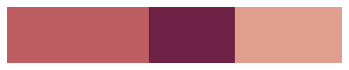

Largest cluster group is  0


True

In [ ]:
########## MERGEEEEEEEEE   ---> JPEG / JPG
###### https://github.com/ssaran046/Image-steganography-using-alternate-LSB-technique-with-clustering-method/blob/master/source/SteganographyClusterBytewise.ipynb



import cv2
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from PIL import Image



class SteganographyException(Exception):
    pass



class LSBteq():
    
    def __init__(self, im, ind):
        self.image=im
        self.index=ind
        self.size=len(ind)
        self.i=0
        self.j=0
        
    def put_binary_value(self, bits): 
       
        for c in bits:
            val = list(self.image[self.index[self.i][0],self.index[self.i][1]]) 
            if int(c) == 1:
                self.image[self.index[self.i][0],self.index[self.i][1]][self.j] = int(val[self.j]) | 1 
            else:
                self.image[self.index[self.i][0],self.index[self.i][1]][self.j] = int(val[self.j]) & 254 
            self.next_slot() 
            
    def put_binary_value_1(self, bits): 
           
        for c in bits:
            val = list(self.image[self.index[self.i][0],self.index[self.i][1]]) 
            if int(c) == 1:
                self.image[self.index[self.i][0],self.index[self.i][1]][self.j] = int(val[self.j]) | 2 
            else:
                self.image[self.index[self.i][0],self.index[self.i][1]][self.j] = int(val[self.j]) & 253
            self.next_slot()
            
            
    def next_slot(self):
        if self.j == 2:           
            self.j = 0
            if self.i >= self.size:
                raise SteganographyException("Sufficien space is not available to store information.")
            else: 
                self.i +=1
        else:
            self.j +=1         
    
    def read_bit(self): 
        val = self.image[self.index[self.i][0],self.index[self.i][1]][self.j]
        print(val)
        val = int(val) & 1
        self.next_slot()
        if val & 1 > 0:
            return "1"
        else:
            return "0"
        
    def read_bit_1(self): 
        val = self.image[self.index[self.i][0],self.index[self.i][1]][self.j]
        val = int(val) & 2
        self.next_slot()
        if val > 0:
            return "1"
        else:
            return "0"          
            
         
    def read_bits(self, nb): 
        bits = ""
        for i in range(nb):
            bits += self.read_bit()
        return bits
    
    def read_bits_1(self, nb): 
        bits = ""
        for i in range(nb):
            bits += self.read_bit_1()
        return bits

    def byteValue(self, val):
        return self.binary_value(val, 8)
        
    def binary_value(self, val, bitsize): 
        binval = bin(val)[2:]
        if len(binval) > bitsize:
            raise SteganographyException("binary value larger than the expected size")
        while len(binval) < bitsize:
            binval = "0"+binval
        
        return binval
        
    def encode_text(self, txt):
        l = len(txt)
        binl = self.binary_value(l, 16) 
        self.put_binary_value(binl)         
        count=0
        for char in txt: 
            c = ord(char)
            if(count %2 ==0):
                self.put_binary_value(self.byteValue(c))
            else:
                self.put_binary_value_1(self.byteValue(c))
            count +=1
        return self.image  
    
    def decode_text(self):
        ls = self.read_bits(16) 
        l = int(ls,2)
        i = 0
        unhideTxt = ""
        while i < l: 
            if(i%2==0):
                tmp = self.read_bits(8) 
            else:
                tmp = self.read_bits_1(8)
            i += 1
            unhideTxt += chr(int(tmp,2)) 
        return unhideTxt



class ClusterImages():
    
    def __init__(self,im):
        
        clf = KMeans(n_clusters=3,n_jobs=-1)
        clf.fit(im)
        
        self.labels = clf.labels_
        self.centers = clf.cluster_centers_
        
    def getCluster(self):
        
        self.hist = self.centroid_histogram()
        self.bar = self.plot_colors()
        self.maxCluster = self.max_cluster()

        return self.labels, self.centers, self.bar, self.maxCluster
        
    def centroid_histogram(self):
        
        numLabels = np.arange(0, len(np.unique(self.labels)) + 1)
        hist, _ = np.histogram(self.labels, bins = numLabels)
        hist = hist.astype("float")
        hist /= hist.sum()
        
        return hist

    def plot_colors(self):
        
        bar = np.zeros((50, 300, 3), dtype = "uint8")
        startX = 0
        for (percent, color) in zip(self.hist, self.centers):
            endX = startX + (percent * 300)
            cv2.rectangle(bar, (int(startX), 0), (int(endX), 50),color.astype("uint8").tolist(), -1)
            startX = endX
    
        return bar
    
    def max_cluster(self):
        
        nLabels = np.arange(0, len(np.unique(self.labels)) + 1)
        countLabels, _ = np.histogram(self.labels, bins = nLabels)
        countLabels = countLabels.tolist()
        maxcluster = countLabels.index(max(countLabels))
        
        return maxcluster


image=cv2.imread("in1.png")
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
image1=image.reshape(image.shape[0] * image.shape[1],3)
labels, centers, bar, maxCluster = ClusterImages(image1).getCluster()

plt.axis("off")
plt.imshow(bar)
plt.show()
print("Largest cluster group is ",maxCluster)



labels=labels.reshape(image.shape[0],image.shape[1])
index1=np.argwhere(labels==maxCluster).tolist()
image=cv2.cvtColor(image,cv2.COLOR_RGB2BGR)
steg=LSBteq(image,index1)
#text = input("Introduceti Mesajul Secret: ")
with open("message.txt", "r") as myfile:
  text = myfile.read()
cv2.imwrite("stego.png",steg.encode_text("text"))

In [ ]:
# decode

img1=cv2.imread("stego.png")
img=cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
image2=img.reshape(img.shape[0] * img.shape[1],3)
labels, centers, bar, maxCluster = ClusterImages(image2).getCluster()
plt.axis("off")
plt.imshow(bar)
plt.show()
print("Largest cluster group is ",maxCluster)
labels=labels.reshape(img.shape[0],img.shape[1])
index2=np.argwhere(labels==maxCluster).tolist()
img=cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
steg=LSBteq(img1,index2)
print(steg.decode_text())

In [ ]:
#### MERGEEEEEEEEEEEE .... paper PNG
### https://analyticsindiamag.com/beginners-guide-to-image-compression-using-k-means-clustering/
### LINK: https://github.com/AnushManglani/Image-Steganography-using-K-Means




import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image
import time


start_time = time.time()
original_img = cv2.imread('in1.png')
o_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
#plt.imshow(o_img)
vector_img = o_img.reshape((-1, 3))


vector_img = np.float32(vector_img)
#plt.imshow(vector_img)
vector_img.shape

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 1.0)
K = 3
attempts = 10
ret, lable, center = cv2.kmeans(vector_img, K, None, criteria, attempts, cv2.KMEANS_PP_CENTERS)

center = np.uint8(center)
res = center[lable.flatten()]
#print(res.shape)
res_image = res.reshape((o_img.shape))
#plt.imshow(res_image)
clustered_img = Image.fromarray(res_image)
clustered_img.save('clustered_img.png')

image_one_array = []
image_two_array = []
image_three_array = []
for i in range(0, len(lable)):
    if lable[i][0] == 0:
        image_one_array.append(vector_img[i])
    elif lable[i][0] == 1:
        image_two_array.append(vector_img[i])
    else:
        image_three_array.append(vector_img[i])

#print(len(image_one_array), len(image_two_array), len(image_three_array))



import math
len1 = len(image_one_array)
len2 = len(image_two_array)
len3 = len(image_three_array)

pad1 = math.ceil(math.sqrt(len1))**2 - len1
pad2 = math.ceil(math.sqrt(len2))**2 - len2
pad3 = math.ceil(math.sqrt(len3))**2 - len3
#print(pad1, pad2, pad3)

white = np.array([255.0, 255.0, 255.0], dtype=np.float32)

for i in range(0, pad1):
    image_one_array.append(white)
    
for i in range(0, pad2):
    image_two_array.append(white)

for i in range(0, pad3):
    image_three_array.append(white)
    
d1 = int(math.sqrt(len(image_one_array)))
#print(len(image_one_array), d1)
d2 = int(math.sqrt(len(image_two_array)))
#print(len(image_two_array), d2)
d3 = int(math.sqrt(len(image_three_array)))
#print(len(image_three_array), d3)

cluster1 = np.uint8(np.array(image_one_array)).reshape((d1, d1, 3))
cluster2 = np.uint8(np.array(image_two_array)).reshape((d2, d2, 3))
cluster3 = np.uint8(np.array(image_three_array)).reshape((d3, d3, 3))

#plt.imshow(cluster1)
cluster1_img = Image.fromarray(cluster1)
cluster1_img.save('cluster1_img.png')

#plt.imshow(cluster2)
cluster2_img = Image.fromarray(cluster2)
cluster2_img.save('cluster2_img.png')

#plt.imshow(cluster3)
cluster3_img = Image.fromarray(cluster3)
cluster3_img.save('cluster3_img.png')








# Funcție care transformă orice tip de dată în binar
def textToBinary(text):
		aux = []

		for i in text:
			aux.append(format(ord(i), '08b'))
		return aux


# Funcție care encodează mesajul secret în pixelii din imagine
def messageInPixel(pixel, text): 
    textList = textToBinary(text) 
    lenText = len(textList) 
    iterator = iter(pixel) 
  
    # pt fiecare byte
    for i in range(lenText): 
        # Extrag câte 3 pixeli o dată (= 9 biți)
        pixel = [value for value in iterator.__next__()[:3] + iterator.__next__()[:3] + iterator.__next__()[:3]] 

        # Schimb val pixelilor în funcție de mesajul secret
        for j in range(0, 8): 
            if (textList[i][j] == '0') and (pixel[j] % 2 != 0): 
                #if (pixel[j] % 2 != 0): 
                pixel[j] -= 1
            elif (textList[i][j] == '1') and (pixel[j] % 2 == 0): 
                pixel[j] -= 1
                  
        # Al 9-lea bit: 0 - continuă citire; 1 - stop (tot mesajul a fost complet codat)  
        if (i == lenText - 1): 
            if (pixel[-1] % 2 == 0): 
                pixel[-1] -= 1
        else: 
            if (pixel[-1] % 2 != 0): 
                pixel[-1] -= 1

        pixel = tuple(pixel) 
        yield pixel[0:3] 
        yield pixel[3:6] 
        yield pixel[6:9]
        

# Funcție care încorporează mesajul secret în poză       
def encodeAux(img, text): 
    w = img.size[0] 
    (x, y) = (0, 0) 
      
    for pixel in messageInPixel(img.getdata(), text): 
        # Pun pixelii modifcați în imagine (Construirea Obiectului Steganografic)
        # Parcurg poza de sus în jos, de la stânga la dreapta (secvențial)
        img.putpixel((x, y), pixel) 
        if (x == w - 1): 
            x = 0
            y += 1
        else: 
            x += 1
            
            
# Funcția Principală pentru Încorporare Mesaj Secret în Poză
def encode(img, text, pozanoua): 
    image = Image.open(img, 'r') 

    if (len(text) == 0): 
        raise ValueError('Mesajul secret nu poate fi gol!') 

    imgAux = image.copy() 
    width, height = imgAux.size

    # Verific ca dimensiunea mesajului secret să nu fie mai mare decât capacitatea pozei
    nr_bytes = width * height * 3 // 8
    if (nr_bytes < len(text)):
      raise ValueError(f"Insuficienti bytes: alegeti o poza cu dimensiuni mai mari sau reduceti marimea mesajului!\nNr maxim de bytes: {nr_bytes}")
    else:
      encodeAux(imgAux, text) 

    #newImg = input("Introduceti Numele Pozei Noi cu extensie: ") 
    imgAux.save(pozanoua, str(pozanoua.split(".")[1].upper()))


# Funcția Principală care Extrage Mesajul Secret din Poză
def decode(img): 
    image = Image.open(img, 'r') 

    text = '' 
    imgdata = iter(image.getdata()) 

    while (True): 
        pixels = [value for value in imgdata.__next__()[:3] + imgdata.__next__()[:3] + imgdata.__next__()[:3]] 
        # String biți
        binstr = '' 
          
        for i in pixels[:8]: 
            if (i % 2 == 0): 
                binstr += '0'
            else: 
                binstr += '1'
                  
        text += chr(int(binstr, 2)) 
        if (pixels[-1] % 2 != 0): 
            return text







#enc_msg = input("Enter the message: ")
enc_msg = "asss sas fgf.read()"
div_len = int(len(enc_msg)//3)
chunk1 = enc_msg[0:div_len]
chunk2 = enc_msg[div_len: 2*div_len]
chunk3 = enc_msg[2*div_len:]
# print(enc_msg)
#print("chunk1:", chunk1)
#print("chunk2:", chunk2)
#print("chunk3:", chunk3)


image_encoded1 = encode('cluster1_img.png', chunk1, 'a.png')
image_encoded2 = encode('cluster2_img.png', chunk2, 'b.png')
image_encoded3 = encode('cluster3_img.png', chunk3, 'c.png')

time = time.time() - start_time
print(f"Timp Executie: {time}")

Timp Executie: 0.5075397491455078


In [ ]:
import time 

start_time = time.time()
decoded_chunk1 = decode('a.png')
decoded_chunk2 = decode('b.png')
decoded_chunk3 = decode('c.png')

decoded_encrypted_msg = decoded_chunk1 + decoded_chunk2 + decoded_chunk3
print("decoded message: ", decoded_encrypted_msg)
time = time.time() - start_time
print(f"Timp Executie: {time}")

decoded message:  asss sas fgf.read()
Timp Executie: 0.010249137878417969


In [ ]:
# original


# https://cryptobook.nakov.com/symmetric-key-ciphers/aes-encrypt-decrypt-examples

import os
import struct
import time

from Crypto.Cipher import AES
from Crypto.Random import get_random_bytes


def encrypt_file(key, in_filename, out_filename=None, chunksize=64 * 1024):
    if not out_filename:
        out_filename = in_filename + '.enc'
    iv = get_random_bytes(AES.block_size)
    encryptor = AES.new(key, AES.MODE_CBC, iv)
    filesize = os.path.getsize(in_filename)
    with open(in_filename, 'rb') as infile:
        with open(out_filename, 'wb') as outfile:
            outfile.write(struct.pack('<Q', filesize))
            outfile.write(iv)
            while True:
                chunk = infile.read(chunksize)
                if len(chunk) == 0:
                    break
                elif len(chunk) % 16 != 0:
                    chunk += b' ' * (16 - len(chunk) % 16)

                outfile.write(encryptor.encrypt(chunk))


def decrypt_file(key, in_filename, out_filename=None, chunksize=24 * 1024):
    if not out_filename:
        out_filename = os.path.splitext(in_filename)[0]
    with open(in_filename, 'rb') as infile:
        origsize = struct.unpack('<Q', infile.read(struct.calcsize('Q')))[0]
        iv = infile.read(16)
        decryptor = AES.new(key, AES.MODE_CBC, iv)
        with open(out_filename, 'wb') as outfile:
            while True:
                chunk = infile.read(chunksize)
                if len(chunk) == 0:
                    break
                outfile.write(decryptor.decrypt(chunk))

            outfile.truncate(origsize)











import hashlib
import random
import numpy as np
from PIL import Image

PLS = []
img = Image.open(r"in1.png")
[row, col] = img.size


def DataListInBit(data):
    dataBits = list(format(c, '08b') for c in bytearray(data.encode('latin-1')))
    return dataBits


def PLSgen(row, col, lenEncodedText):
    new = []
    for i in range(row * col):
        new.append(i)
    for i in range(len(new) - 1, 0, -1):
        j = random.randint(0, i + 1)
        new[i], new[j] = new[j], new[i]
    for i in range(lenEncodedText * 3):
        PLS.append(new[i])
    pixelLocaterSequence = np.array(PLS)
    np.savetxt("pls.txt", pixelLocaterSequence, delimiter="\t")


def LsbEncoding(encodedText):
    PLSgen(row, col, len(encodedText))
    dataBits = DataListInBit(encodedText)
    dr = 0
    for i in range(0, len(encodedText) * 3, 3):
        dc = 0
        for j in range(0, 3):
            rr = PLS[i + j] // col
            rc = PLS[i + j] % col
            rgb = img.getpixel((rr, rc))
            value = []
            idx = 0
            for k in rgb:
                if (k % 2 == 0 and dataBits[dr][dc] == '1'):
                    if (k == 0):
                        k += 1
                    else:
                        k -= 1
                if (k % 2 == 1 and dataBits[dr][dc] == '0'):
                    k -= 1
                value.append(k)
                idx += 1
                dc += 1
                if (dc >= 8):
                    break
            if (dc >= 8):
                value.append(rgb[2])
            newrgb = (value[0], value[1], value[2])
            img.putpixel((rr, rc), newrgb)
        dr += 1
    img.save("out1.png")
    plsPassword = input("Insert Password for pls encyption :")
    key = hashlib.sha256(plsPassword.encode()).digest()
    encrypt_file(key, 'pls.txt')





def messageInPixel(pixel, text): 
    textList = DataListInBit(text) 
    lenText = len(textList) 
    iterator = iter(pixel) 
  
    # pt fiecare byte
    for i in range(lenText): 
        # Extrag câte 3 pixeli o dată (= 9 biți)
        pixel = [value for value in iterator.__next__()[:3] + iterator.__next__()[:3] + iterator.__next__()[:3]] 

        # Schimb val pixelilor în funcție de mesajul secret
        for j in range(0, 8): 
            if (textList[i][j] == '0') and (pixel[j] % 2 != 0): 
                #if (pixel[j] % 2 != 0): 
                pixel[j] -= 1
            elif (textList[i][j] == '1') and (pixel[j] % 2 == 0): 
                pixel[j] -= 1
                  
        # Al 9-lea bit: 0 - continuă citire; 1 - stop (tot mesajul a fost complet codat)  
        if (i == lenText - 1): 
            if (pixel[-1] % 2 == 0): 
                pixel[-1] -= 1
        else: 
            if (pixel[-1] % 2 != 0): 
                pixel[-1] -= 1

        pixel = tuple(pixel) 
        yield pixel[0:3] 
        yield pixel[3:6] 
        yield pixel[6:9]
        

# Funcție care încorporează mesajul secret în poză       
def encodeAux(img, text): 
    w = img.size[0] 
    (x, y) = (0, 0) 
      
    for pixel in messageInPixel(img.getdata(), text): 
        # Pun pixelii modifcați în imagine (Construirea Obiectului Steganografic)
        # Parcurg poza de sus în jos, de la stânga la dreapta (secvențial)
        img.putpixel((x, y), pixel) 
        if (x == w - 1): 
            x = 0
            y += 1
        else: 
            x += 1

def encode(): 
    #img = input("Introduceti Imaginea cu extensie: ") 
    image = Image.open("in3.png", 'r') 

    """
    text = input("Introduceti Mesajul Secret: ") 
    if (len(text) == 0): 
        raise ValueError('Mesajul secret nu poate fi gol!') 
    """
    with open("message.txt", "r") as myfile:
      text = myfile.read()
    
    #passwordText = input("Password :")
    encodedMessage = encrypt(text, "123")
    #print(encodedMessage)

    imgAux = image.copy() 
    width, height = imgAux.size

    # Verific ca dimensiunea mesajului secret să nu fie mai mare decât capacitatea pozei
    nr_bytes = width * height * 3 // 8
    if (nr_bytes < len(text)):
      raise ValueError(f"Insuficienti bytes: alegeti o poza cu dimensiuni mai mari sau reduceti marimea mesajului!\nNr maxim de bytes: {nr_bytes}")
    else:
      PLSgen(width, height, len(encodedMessage))
      encodeAux(imgAux, encodedMessage) 

    #newImg = input("Introduceti Numele Pozei Noi cu extensie: ") 
    imgAux.save("out1.png", str("out1.png".split(".")[1].upper()))

    #plsPassword = input("Insert Password for pls encyption :")
    key = hashlib.sha256("456".encode()).digest()
    encrypt_file(key, 'pls.txt')


# Funcția Principală care Extrage Mesajul Secret din Poză
def decode(): 
    #plspassword = input("Insert Password for pls decryption :")
    key = hashlib.sha256("456".encode()).digest()
    decrypt_file(key, 'pls.txt.enc', 'out.txt')
    pls = np.genfromtxt('out.txt', delimiter='\t')
    
    image = Image.open(r"out1.png")

    #img = input("Introduceti Imaginea cu extensie: ") 
    #image = Image.open(img, 'r') 

    text = '' 
    imgdata = iter(image.getdata()) 

    while (True): 
        pixels = [value for value in imgdata.__next__()[:3] + imgdata.__next__()[:3] + imgdata.__next__()[:3]] 
        # String biți
        binstr = '' 
          
        for i in pixels[:8]: 
            if (i % 2 == 0): 
                binstr += '0'
            else: 
                binstr += '1'
                  
        text += chr(int(binstr, 2)) 
        if (pixels[-1] % 2 != 0): 
            return text







def LsbDecoding():
    plspassword = input("Insert Password for pls decryption :")
    key = hashlib.sha256(plspassword.encode()).digest()
    decrypt_file(key, 'pls.txt.enc', 'out.txt')
    pls = np.genfromtxt('out.txt', delimiter='\t')
    if os.path.exists("out.txt"):
        os.remove("out.txt")
    if os.path.exists("pls.txt.enc"):
        os.remove("pls.txt.enc")
    decodedTextInBits = []
    stegoImage = Image.open(r"out1.png")
    for i in range(0, len(pls), 3):
        ithChar = ""
        for j in range(0, 3):
            rr = pls[i + j] // col
            rc = pls[i + j] % col
            rgb = stegoImage.getpixel((rr, rc))
            for k in rgb:
                if (k & 1):
                    ithChar += '1'
                else:
                    ithChar += '0'

        ithChar = ithChar[:-1]
        decodedTextInBits.append((ithChar))
    decodedText = ''
    for i in decodedTextInBits:
        decodedText += chr(int(i, 2))
    return decodedText


























import binascii
import pbkdf2
import pyaes

passwordSalt = b'\\`\xd6\xdaB\x03\xdd\xd4z\xb6p\xe8O\xf0\xa8\xc0'
iv = 113573230825063269301116483319046608643543151989648198772824118452040014644050


def encrypt(raw, password):
    key = pbkdf2.PBKDF2(password, passwordSalt).read(32)
    aes = pyaes.AESModeOfOperationCTR(key, pyaes.Counter(iv))
    cipherByte = aes.encrypt(raw)
    return binascii.hexlify(cipherByte).decode('utf-8')


def decrypt(cipherText, password):
    res = bytes(cipherText, 'utf-8')
    cipherByte = binascii.unhexlify(res)
    key = pbkdf2.PBKDF2(password, passwordSalt).read(32)
    aes = pyaes.AESModeOfOperationCTR(key, pyaes.Counter(iv))
    originalByte = aes.decrypt(cipherByte)
    return originalByte.decode('utf-8')












import os


def main():
    select = input("Enter E for Encoding D for Decoding :")
    if select == 'E':

        """
        secretMessage = input("Enter the secret message :")
        passwordText = input("Password :")
        encodedMessage = encrypt(secretMessage, passwordText)
        print(encodedMessage)
        LsbEncoding(encodedMessage)
        """
        encode()



    if select == 'D':
        if os.path.exists("pls.txt.enc"):
            #decodedText = LsbDecoding()
            #print(decodedText)
            decodedText = decode()

            password = input("Enter the password :")
            finalMessage = decrypt(decodedText, password)
            print("Final message :", finalMessage)
        else :
            print("PLS file is not present !")




#main()

start_time = time.time()
#encode()

"""
decodedText = decode()
finalMessage = decrypt(decodedText, "123")
print("Final message :", finalMessage)
time = time.time() - start_time"""

#time = time.time() - start_time
print(f"Timp Executie: {time}")

In [ ]:
######## LINK: https://github.com/MasonEdgar/DCT-Image-Steganography









#------ External Libraries ------#
import cv2
import struct
import bitstring
import numpy  as np
import time




## ZZ -> ZigZag
# Zigzag scan of a matrix
# Argument is a two-dimensional matrix of any size,
# not strictly a square one.
# Function returns a 1-by-(m*n) array,
# where m and n are sizes of an input matrix,
# consisting of its items scanned by a zigzag method.
def zigzag(input):
	#initializing the variables
	#----------------------------------
	h = 0
	v = 0

	vmin = 0
	hmin = 0

	vmax = input.shape[0]
	hmax = input.shape[1]

	#print(vmax ,hmax )

	i = 0

	output = np.zeros(( vmax * hmax))
	#----------------------------------

	while ((v < vmax) and (h < hmax)):

		if ((h + v) % 2) == 0:                 # going up

			if (v == vmin):
				#print(1)
				output[i] = input[v, h]        # if we got to the first line

				if (h == hmax):
					v = v + 1
				else:
					h = h + 1

				i = i + 1

			elif ((h == hmax -1 ) and (v < vmax)):   # if we got to the last column
				#print(2)
				output[i] = input[v, h]
				v = v + 1
				i = i + 1

			elif ((v > vmin) and (h < hmax -1 )):    # all other cases
				#print(3)
				output[i] = input[v, h]
				v = v - 1
				h = h + 1
				i = i + 1


		else:                                    # going down

			if ((v == vmax -1) and (h <= hmax -1)):       # if we got to the last line
				#print(4)
				output[i] = input[v, h]
				h = h + 1
				i = i + 1

			elif (h == hmin):                  # if we got to the first column
				#print(5)
				output[i] = input[v, h]

				if (v == vmax -1):
					h = h + 1
				else:
					v = v + 1

				i = i + 1

			elif ((v < vmax -1) and (h > hmin)):     # all other cases
				#print(6)
				output[i] = input[v, h]
				v = v + 1
				h = h - 1
				i = i + 1




		if ((v == vmax-1) and (h == hmax-1)):          # bottom right element
			#print(7)
			output[i] = input[v, h]
			break

	#print ('v:',v,', h:',h,', i:',i)
	return output




# Inverse zigzag scan of a matrix
# Arguments are: a 1-by-m*n array,
# where m & n are vertical & horizontal sizes of an output matrix.
# Function returns a two-dimensional matrix of defined sizes,
# consisting of input array items gathered by a zigzag method.
def inverse_zigzag(input, vmax, hmax):

	#print input.shape

	# initializing the variables
	#----------------------------------
	h = 0
	v = 0

	vmin = 0
	hmin = 0

	output = np.zeros((vmax, hmax))

	i = 0
	#----------------------------------

	while ((v < vmax) and (h < hmax)):
		#print ('v:',v,', h:',h,', i:',i)
		if ((h + v) % 2) == 0:                 # going up

			if (v == vmin):
				#print(1)

				output[v, h] = input[i]        # if we got to the first line

				if (h == hmax):
					v = v + 1
				else:
					h = h + 1

				i = i + 1

			elif ((h == hmax -1 ) and (v < vmax)):   # if we got to the last column
				#print(2)
				output[v, h] = input[i]
				v = v + 1
				i = i + 1

			elif ((v > vmin) and (h < hmax -1 )):    # all other cases
				#print(3)
				output[v, h] = input[i]
				v = v - 1
				h = h + 1
				i = i + 1


		else:                                    # going down

			if ((v == vmax -1) and (h <= hmax -1)):       # if we got to the last line
				#print(4)
				output[v, h] = input[i]
				h = h + 1
				i = i + 1

			elif (h == hmin):                  # if we got to the first column
				#print(5)
				output[v, h] = input[i]
				if (v == vmax -1):
					h = h + 1
				else:
					v = v + 1
				i = i + 1

			elif((v < vmax -1) and (h > hmin)):     # all other cases
				output[v, h] = input[i]
				v = v + 1
				h = h - 1
				i = i + 1




		if ((v == vmax-1) and (h == hmax-1)):          # bottom right element
			#print(7)
			output[v, h] = input[i]
			break


	return output













# Image Preparation
# Numpy Macros
HORIZ_AXIS = 1
VERT_AXIS  = 0

# Standard quantization table as defined by JPEG
JPEG_STD_LUM_QUANT_TABLE = np.asarray([
                                        [16, 11, 10, 16,  24, 40,   51,  61],
                                        [12, 12, 14, 19,  26, 58,   60,  55],
                                        [14, 13, 16, 24,  40, 57,   69,  56],
                                        [14, 17, 22, 29,  51, 87,   80,  62],
                                        [18, 22, 37, 56,  68, 109, 103,  77],
                                        [24, 36, 55, 64,  81, 104, 113,  92],
                                        [49, 64, 78, 87, 103, 121, 120, 101],
                                        [72, 92, 95, 98, 112, 100, 103,  99]
                                      ],
                                      dtype = np.float32)
# Image container class
class YCC_Image(object):
    def __init__(self, cover_image):
        self.height, self.width = cover_image.shape[:2]
        self.channels = [
                         split_image_into_8x8_blocks(cover_image[:,:,0]),
                         split_image_into_8x8_blocks(cover_image[:,:,1]),
                         split_image_into_8x8_blocks(cover_image[:,:,2]),
                        ]

#====================================================================================================#
#====================================================================================================#

def stitch_8x8_blocks_back_together(Nc, block_segments):
    '''
    Take the array of 8x8 pixel blocks and put them together by row so the numpy.block() method can sitch it back together
    :param Nc: Number of pixels in the image (length-wise)
    :param block_segments:
    :return:
    '''
    image_rows = []
    temp = []
    for i in range(len(block_segments)):
        if i > 0 and not(i % int(Nc / 8)):
            image_rows.append(temp)
            temp = [block_segments[i]]
        else:
            temp.append(block_segments[i])
    image_rows.append(temp)

    return np.block(image_rows)

#====================================================================================================#
#====================================================================================================#

def split_image_into_8x8_blocks(image):
    blocks = []
    for vert_slice in np.vsplit(image, int(image.shape[0] / 8)):
        for horiz_slice in np.hsplit(vert_slice, int(image.shape[1] / 8)):
            blocks.append(horiz_slice)
    return blocks






















# Data Embeding
def extract_encoded_data_from_DCT(dct_blocks):
    extracted_data = ""
    for current_dct_block in dct_blocks:
        for i in range(1, len(current_dct_block)):
            curr_coeff = np.int32(current_dct_block[i])
            if (curr_coeff > 1):
                extracted_data += bitstring.pack('uint:1', np.uint8(current_dct_block[i]) & 0x01)
    return extracted_data

# ============================================================================= #
# ============================================================================= #
# ============================================================================= #
# ============================================================================= #

def embed_encoded_data_into_DCT(encoded_bits, dct_blocks):
    data_complete = False; encoded_bits.pos = 0
    encoded_data_len = bitstring.pack('uint:32', len(encoded_bits))
    converted_blocks = []
    for current_dct_block in dct_blocks:
        for i in range(1, len(current_dct_block)):
            curr_coeff = np.int32(current_dct_block[i])
            if (curr_coeff > 1):
                curr_coeff = np.uint8(current_dct_block[i])
                if (encoded_bits.pos == (len(encoded_bits) - 1)): data_complete = True; break
                pack_coeff = bitstring.pack('uint:8', curr_coeff)
                if (encoded_data_len.pos <= len(encoded_data_len) - 1): pack_coeff[-1] = encoded_data_len.read(1)
                else: pack_coeff[-1] = encoded_bits.read(1)
                # Replace converted coefficient
                current_dct_block[i] = np.float32(pack_coeff.read('uint:8'))
        converted_blocks.append(current_dct_block)

    if not(data_complete): raise ValueError("Data didn't fully embed into cover image!")

    return converted_blocks












def encrypt():
  NUM_CHANNELS = 3
  COVER_IMAGE_FILEPATH  = "in3.png" # Choose your cover image (PNG)
  STEGO_IMAGE_FILEPATH  = "out1.png"
  with open("message.txt", "r") as myfile:
    SECRET_MESSAGE_STRING = myfile.read()
  #SECRET_MESSAGE_STRING = "ddvbvbsdjhvbsjvbsl abclsvgas ahdcvbsdahkcvu"

# ============================================================================= #
# ============================================================================= #
# =========================== BEGIN CODE OPERATION ============================ #
# ============================================================================= #
# ============================================================================= #

  raw_cover_image = cv2.imread(COVER_IMAGE_FILEPATH, flags=cv2.IMREAD_COLOR)
  height, width   = raw_cover_image.shape[:2]

# Force Image Dimensions to be 8x8 compliant
  while(height % 8): height += 1 # Rows
  while(width  % 8): width  += 1 # Cols
  valid_dim = (width, height)
  padded_image    = cv2.resize(raw_cover_image, valid_dim)
  cover_image_f32 = np.float32(padded_image)
  cover_image_YCC = YCC_Image(cv2.cvtColor(cover_image_f32, cv2.COLOR_BGR2YCrCb))

# Placeholder for holding stego image data
  stego_image = np.empty_like(cover_image_f32)

  for chan_index in range(NUM_CHANNELS):
    # FORWARD DCT STAGE
    dct_blocks = [cv2.dct(block) for block in cover_image_YCC.channels[chan_index]]

    # QUANTIZATION STAGE
    dct_quants = [np.around(np.divide(item, JPEG_STD_LUM_QUANT_TABLE)) for item in dct_blocks]

    # Sort DCT coefficients by frequency
    sorted_coefficients = [zigzag(block) for block in dct_quants]

    # Embed data in Luminance layer
    if (chan_index == 0):
        # DATA INSERTION STAGE
        secret_data = ""
        for char in SECRET_MESSAGE_STRING.encode('ascii'): secret_data += bitstring.pack('uint:8', char)
        embedded_dct_blocks   = embed_encoded_data_into_DCT(secret_data, sorted_coefficients)
        desorted_coefficients = [inverse_zigzag(block, vmax=8,hmax=8) for block in embedded_dct_blocks]
    else:
        # Reorder coefficients to how they originally were
        desorted_coefficients = [inverse_zigzag(block, vmax=8,hmax=8) for block in sorted_coefficients]

    # DEQUANTIZATION STAGE
    dct_dequants = [np.multiply(data, JPEG_STD_LUM_QUANT_TABLE) for data in desorted_coefficients]

    # Inverse DCT Stage
    idct_blocks = [cv2.idct(block) for block in dct_dequants]

    # Rebuild full image channel
    stego_image[:,:,chan_index] = np.asarray(stitch_8x8_blocks_back_together(cover_image_YCC.width, idct_blocks))
#-------------------------------------------------------------------------------------------------------------------#

# Convert back to RGB (BGR) Colorspace
  stego_image_BGR = cv2.cvtColor(stego_image, cv2.COLOR_YCR_CB2BGR)

# Clamp Pixel Values to [0 - 255]
  final_stego_image = np.uint8(np.clip(stego_image_BGR, 0, 255))

# Write stego image
  cv2.imwrite(STEGO_IMAGE_FILEPATH, final_stego_image)

"""
start_time = time.time()
encrypt()
time = time.time() - start_time
print(f"Timp: {time}")"""



def decrypt():
  stego_image     = cv2.imread("out1.png", flags=cv2.IMREAD_COLOR)
  stego_image_f32 = np.float32(stego_image)
  stego_image_YCC = YCC_Image(cv2.cvtColor(stego_image_f32, cv2.COLOR_BGR2YCrCb))

# FORWARD DCT STAGE
  dct_blocks = [cv2.dct(block) for block in stego_image_YCC.channels[0]]  # Only care about Luminance layer

# QUANTIZATION STAGE
  dct_quants = [np.around(np.divide(item, JPEG_STD_LUM_QUANT_TABLE)) for item in dct_blocks]

# Sort DCT coefficients by frequency
  sorted_coefficients = [zigzag(block) for block in dct_quants]

# DATA EXTRACTION STAGE
  recovered_data = extract_encoded_data_from_DCT(sorted_coefficients)

# Determine length of secret message
  data_len = int(recovered_data.read('uint:32') / 8)

# Extract secret message from DCT coefficients
  extracted_data = bytes()
  for _ in range(data_len): extracted_data += struct.pack('>B', recovered_data.read('uint:8'))

# Print secret message back to the user
  print(extracted_data.decode('ascii'))


start_time = time.time()
decrypt()
time = time.time() - start_time
print(f"Timp: {time}")

In [ ]:
import math
import cv2
import numpy as np

def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    err = np.sum((original.astype("float") - compressed.astype("float")) ** 2)
    err /= float(original.shape[0] * original.shape[1])
    if (mse == 0):
        return 100
    max_pixel = 255.0
    print("MSE manual: ", mse)
    psnr = 20 * math.log10(max_pixel / math.sqrt(mse))
    return psnr



def calculate_psnr(img1, img2):
    # img1 and img2 have range [0, 255]
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    mse = np.mean((img1 - img2)**2)
    print(f"MSE 2: {mse}")
    if mse == 0:
        return float('inf')
    return 20 * math.log10(255.0 / math.sqrt(mse))




def ssim(img1, img2):
    C1 = (0.01 * 255)**2
    C2 = (0.03 * 255)**2

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]  # valid
    mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(img1**2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(img2**2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                            (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()




def calculate_ssim(img1, img2):
    if not img1.shape == img2.shape:
        raise ValueError('Input images must have the same dimensions.')
    if img1.ndim == 2:
        return ssim(img1, img2)
    elif img1.ndim == 3:
        if img1.shape[2] == 3:
            ssims = []
            for i in range(3):
                ssims.append(ssim(img1, img2))
            return np.array(ssims).mean()
        elif img1.shape[2] == 1:
            return ssim(np.squeeze(img1), np.squeeze(img2))
    else:
        raise ValueError('Wrong input image dimensions.')



def main():
    original = cv2.imread("in3.png")
    compressed = cv2.imread("out3.png")

    s = calculate_ssim(original, compressed)
    print(f"SSIM manual: {s}")

    value = PSNR(original, compressed)
    print(f"PSNR manual: {value}")

    value = calculate_psnr(original, compressed)
    print(f"PSNR new: {value}")


main()

SSIM manual: 0.8307624012495465
MSE manual:  62.106650034586586
PSNR manual: 30.1994225636443
MSE 2: 153.95267868041992
PSNR new: 26.256931111103142


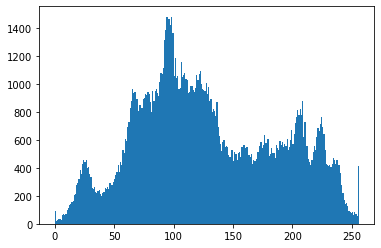

"\nimg1 = cv2.imread('out1.png', 1)\nplt.hist(img1.ravel(),256,[0,256])\nplt.show()\n"

In [ ]:
#histogramă
import cv2
from matplotlib import pyplot as plt
img1 = cv2.imread('in1.png', 1)
plt.hist(img1.ravel(),256,[0,256])
plt.show()

"""
img1 = cv2.imread('out1.png', 1)
plt.hist(img1.ravel(),256,[0,256])
plt.show()
"""

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def histograma(img, string):
  img = cv2.imread(img, -1)
  color = ('b','g','r')
  for channel,col in enumerate(color):
    histr = cv2.calcHist([img],[channel],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
  
  plt.savefig("p"+string, dpi=300, bbox_inches='tight')
  plt.title('Histogram '+string)
  plt.show()


histograma("cluster1_img.png", "cluster1_img.png")
histograma("a.png", "a.png")

histograma("cluster2_img.png", "cluster2_img.png")
histograma("b.png", "b.png")

histograma("cluster3_img.png", "cluster3_img.png")
histograma("c.png", "c.png")